# 📊 Análisis espectral de la aceleración
Esta plantilla te ayudará a:
- Cargar una señal de aceleración vs tiempo
- Aplicar la Transformada Discreta de Fourier (DFT)
- Identificar los armónicos dominantes
- Reconstruir la señal con los primeros armónicos

👉 Asegúrate de tener tus datos en un archivo `.txt` o `.csv` con columnas de tiempo y aceleración.

In [296]:
# ✅ Librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (12, 5)


## 📁 1. Cargar archivo de datos
Modifica esta celda para que apunte a tu archivo de datos con columnas de tiempo y aceleración.

In [324]:
# Cargar datos desde archivo
# Reemplaza 'archivo.txt' con el nombre de tu archivo
df = pd.read_csv("../Datos-medidos/1era-medida-muestreo75.txt", sep="\t", skiprows=200)
df.columns = ['Tiempo','Ángulo', 'Velocidad1', 'Aceleración1', 'Posición','Velocidad2','Aceleración2']

# Visualizar las primeras filas
df.head()

,Tiempo,Ángulo,Velocidad1,Aceleración1,Posición,Velocidad2,Aceleración2
0,2.600000,-3.071779,-3.127048,-2.272564,0.337855,0.177335763889,-0.269705584491
1,2.613333,-3.106686,-2.945243,-6.666188,,,
2,2.626667,-3.141593,-3.272492,-11.665829,,,
3,2.640000,-3.193953,-3.563381,2.499821,0.344372,0.169118055556,-0.223803530093
4,2.653333,-3.246312,-3.236131,18.407769,,,


## 🔍 2. Seleccionar intervalo aproximadamente periódico
Selecciona una parte de la señal donde se vea un comportamiento cíclico.

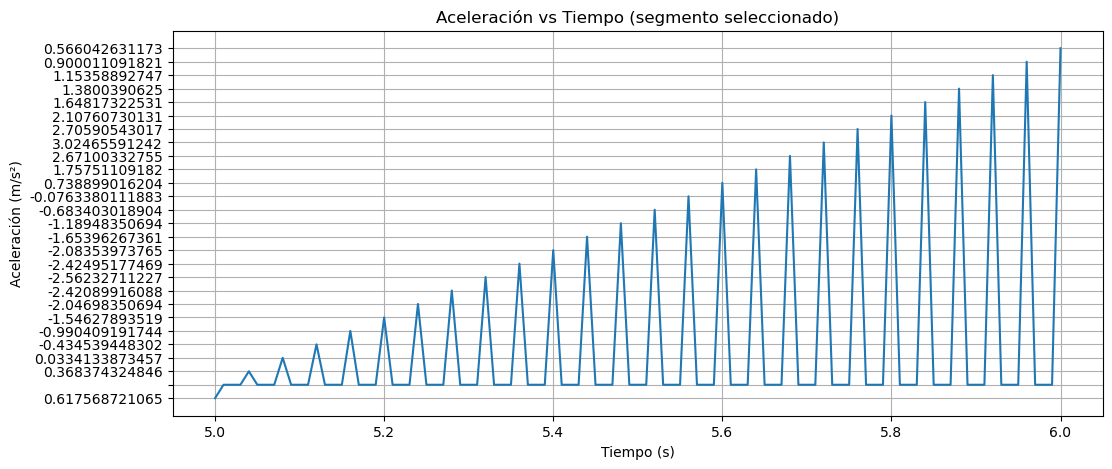

In [319]:
# Acotar datos a un intervalo periódico
inicio, fin = 5, 6  # segundos
mask = (df['Tiempo'] >= inicio) & (df['Tiempo'] <= fin)
t = df.loc[mask, 'Tiempo'].values
a = df.loc[mask, 'Aceleración2'].values

# Mostrar la señal
plt.plot(t, a)
plt.title("Aceleración vs Tiempo (segmento seleccionado)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Aceleración (m/s²)")
#plt.xticks(np.arange(t[0], t[-1], 1))  # marcas cada 0.1 segundos
plt.grid()
plt.show()

## ⚙️ 3. Calcular la DFT y obtener el espectro de amplitudes

In [317]:
# Parámetros de muestreo
N = len(t)
T = t[1] - t[0]
print(T)
f_s = 1 / T # Frecuencia de muestreo 

# FFT
yf = fft(a)
xf = fftfreq(N, T)[:N // 2]
amplitudes = 2.0 / N * np.abs(yf[:N // 2])

# Espectro
plt.stem(xf, amplitudes)
plt.title("Espectro de Fourier")
plt.xlabel("Frecuencia (Hz) ó ciclos por segundo")
plt.ylabel("Amplitud")
#plt.xlim(0, 25)
plt.grid()
plt.show()

0.009999999999999787


ValueError: could not convert string to float: ' '

## 📌 4. Identificar los dos primeros armónicos dominantes

In [304]:
# FFT previa: asume que ya tienes xf y amplitudes
threshold = np.max(amplitudes) * 0.2
rango_frecuencias = (xf >= 0) & (xf <= 5)
condicion = (amplitudes > threshold) & rango_frecuencias

filtered_freqs = xf[condicion]
filtered_amps = amplitudes[condicion]

# Crear tabla ordenada por frecuencia (no por amplitud)
dominant_df_filtered = pd.DataFrame({
    "Frecuencia (Hz)": filtered_freqs,
    "Amplitud": filtered_amps
}).sort_values(by="Frecuencia (Hz)").reset_index(drop=True)

# Mostrar la tabla
print(dominant_df_filtered.head())

   Frecuencia (Hz)  Amplitud
0              0.8  0.447300
1              0.9  1.690941
2              1.0  0.865548
3              2.8  0.423740


In [231]:
dominant_df_filtered

,Frecuencia (Hz),Amplitud
0,1.000000,1.918021
1,1.571429,2.185818
2,1.714286,2.110944
3,1.857143,6.785008
4,2.000000,1.771183
5,3.428571,2.220552
6,3.714286,2.679623


In [262]:
dominant_df_filtered["Frecuencia (Hz)"][0]*2*np.pi

np.float64(6.283185307179586)

## 🧱 5. Reconstrucción de la señal con los dos primeros armónicos

-0.5334057416780951
-0.8412598009242228
2.0172842035835434


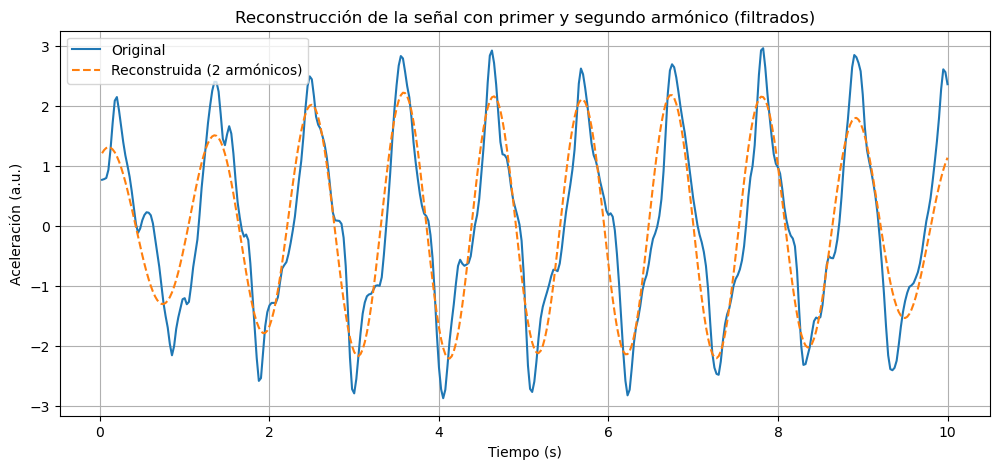

,Frecuencia (Hz),Amplitud
0,0.8,0.447300
1,0.9,1.690941
2,1.0,0.865548
3,2.8,0.423740


In [305]:
# Reconstrucción con las dos primeras frecuencias físicas ordenadas
phases = np.angle(yf)
reconstructed = np.zeros_like(t)

for f in dominant_df_filtered["Frecuencia (Hz)"].head(3):  # solo las dos primeras por frecuencia
    idx = np.argmin(np.abs(xf - f))
    A = amplitudes[idx]
    phi = phases[idx]
    print(phi)
    reconstructed += A * np.cos(2 * np.pi * f * t + phi)

# Comparación visual
plt.plot(t, a, label="Original")
plt.plot(t, reconstructed, label="Reconstruida (2 armónicos)", linestyle="--")
plt.title("Reconstrucción de la señal con primer y segundo armónico (filtrados)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Aceleración (a.u.)")
plt.legend()
plt.grid()
plt.show()
display(dominant_df_filtered)

## ✏️ 6. Conclusión
Comenta lo siguiente:
- ¿Qué tan bien se aproxima la reconstrucción a la señal original?
- ¿Qué información se pierde?
- ¿Los armónicos encontrados tienen sentido físico?
- ¿Hay otros picos en el espectro? ¿Podrían deberse a ruido o efectos mecánicos del sistema?